In [9]:
from IPython.display import display
import os

# 上傳檔案（會跳出檔案選擇器）
from ipywidgets import FileUpload

upload = FileUpload()
display(upload)

FileUpload(value=(), description='Upload')

In [10]:
import os
from pathlib import Path

# 假設你只上傳了一個檔案
fileinfo = upload.value[0]  # 通常是一個 dict，含 'name' 和 'content'

# 顯示內容結構（除錯用）
print(fileinfo)

# 儲存 kaggle.json
filename = fileinfo['name']
content = fileinfo['content']

kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)

kaggle_json_path = kaggle_dir / "kaggle.json"
with open(kaggle_json_path, "wb") as f:
    f.write(content)

# 設定權限（Linux/macOS 建議）
os.chmod(kaggle_json_path, 0o600)

print(f"{filename} 已成功儲存至 {kaggle_json_path}")

{'name': 'kaggle.json', 'type': 'application/json', 'size': 64, 'content': <memory at 0x7773fc537f40>, 'last_modified': datetime.datetime(2025, 4, 21, 6, 7, 11, 972000, tzinfo=datetime.timezone.utc)}
kaggle.json 已成功儲存至 /home/jovyan/.kaggle/kaggle.json


In [11]:
!kaggle datasets list -s cifar


ref                                                     title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------  ----------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
fedesoriano/cifar100                                    CIFAR-100 Python                                  168517809  2020-12-26 08:37:10.143000          12153        176  1.0              
pankrzysiu/cifar10-python                               CIFAR-10 Python                                   340613496  2018-01-27 13:42:40.967000          14641        251  0.75             
petitbonney/cifar10-image-recognition                   CIFAR-10                                         1007971063  2019-10-01 12:50:23.227000           2794         24  0.8235294        
valentynsichkar/cifar10-preprocessed                   

In [12]:
!pip install -U kaggle
!pip install --upgrade pandas
import os
import zipfile

# 建立 Kaggle 資料夾
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 下載 Dog Breed Identification 資料集
!kaggle competitions download -c dog-breed-identification --force
!unzip -oq dog-breed-identification.zip -d dog-breed-identification


import pandas as pd
import numpy as np

labels = pd.read_csv('dog-breed-identification/labels.csv')


cp: cannot stat 'kaggle.json': No such file or directory
 99%|████████████████████████████████████████▍| 682M/691M [00:04<00:00, 164MB/s]
100%|█████████████████████████████████████████| 691M/691M [00:04<00:00, 160MB/s]


In [13]:
import os
import shutil
import pandas as pd
from PIL import Image
from tqdm import tqdm
# 讀取標籤
labels = pd.read_csv('dog-breed-identification/labels.csv')
# 建立目標輸出資料夾
output_dir = "dog_images"
train_dir = os.path.join(output_dir, "train")
os.makedirs(train_dir, exist_ok=True)

# 根據標籤將圖片存入對應資料夾
def organize_train_images(labels): # Pass labels as an argument
    src_img_dir = "dog-breed-identification/train"
    for idx, row in tqdm(labels.iterrows(), total=len(labels)):
        img_id = row['id']
        breed = row['breed']
        src_path = os.path.join(src_img_dir, img_id + ".jpg")

        # 建立品種對應資料夾
        breed_dir = os.path.join(train_dir, breed)
        os.makedirs(breed_dir, exist_ok=True)

        dst_path = os.path.join(breed_dir, img_id + ".jpg")
        shutil.copyfile(src_path, dst_path)

# Load labels outside the function
labels = pd.read_csv('dog-breed-identification/labels.csv')
organize_train_images(labels) # Call the function with labels argument

100%|██████████| 10222/10222 [00:57<00:00, 177.79it/s]


In [14]:
 #自定義 Dataset 類別
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class DogBreedImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # 建立類別對應表：品種 → 數值 label
        class_names = sorted(os.listdir(root_dir))
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        for class_name in class_names:
            class_folder = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_folder):
                continue
            for filename in os.listdir(class_folder):
                if filename.endswith(('.jpg', '.png')):
                    self.image_paths.append(os.path.join(class_folder, filename))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [15]:
# 定義 Transform
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, ColorJitter, RandomRotation, ToTensor, Normalize

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # 隨機縮放裁切
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),  # 使用 ImageNet 的 mean/std
                         (0.229, 0.224, 0.225)),
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3),
])

In [16]:
#建立 Dataset 與切分
from torch.utils.data import random_split, DataLoader
import collections

# 讀取分類後資料
dataset = DogBreedImageFolder("dog_images/train", transform=train_transform)

# 計算資料數量與切分比例
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 測試集 Dataset（未提供 labels.csv 的 test set 可略過）
# test_dataset = DogBreedImageFolder("dog_images/test", transform=test_transform)

# 檢查各類資料數量
train_labels = [label for _, label in train_dataset]
val_labels = [label for _, label in val_dataset]
print("Train label distribution:", collections.Counter(train_labels))
print("Val label distribution:", collections.Counter(val_labels))


Train label distribution: Counter({97: 96, 42: 94, 1: 93, 73: 92, 7: 91, 11: 90, 52: 90, 26: 90, 100: 89, 94: 89, 3: 88, 87: 86, 9: 86, 93: 85, 69: 85, 59: 85, 68: 84, 75: 83, 61: 83, 55: 81, 109: 80, 80: 79, 101: 79, 102: 79, 84: 78, 57: 77, 70: 77, 13: 77, 78: 74, 98: 74, 60: 73, 19: 73, 117: 73, 17: 72, 8: 72, 6: 72, 95: 72, 56: 72, 39: 71, 63: 71, 2: 71, 14: 70, 20: 70, 15: 70, 79: 69, 74: 69, 114: 69, 88: 69, 10: 69, 30: 69, 90: 69, 118: 68, 96: 68, 92: 68, 82: 67, 62: 67, 33: 67, 116: 67, 35: 67, 107: 66, 110: 66, 53: 66, 27: 65, 67: 65, 104: 65, 86: 65, 37: 64, 18: 64, 50: 64, 40: 63, 58: 63, 32: 63, 5: 63, 81: 63, 103: 62, 64: 62, 31: 62, 12: 62, 111: 62, 77: 61, 71: 61, 54: 61, 28: 61, 106: 61, 0: 61, 72: 61, 91: 61, 44: 61, 115: 61, 25: 60, 36: 60, 99: 60, 76: 60, 45: 60, 21: 60, 105: 59, 113: 59, 46: 58, 29: 58, 47: 58, 83: 57, 24: 57, 51: 57, 41: 57, 48: 56, 38: 56, 108: 56, 16: 56, 65: 56, 119: 56, 4: 55, 112: 54, 85: 54, 66: 53, 43: 53, 89: 52, 34: 52, 22: 51, 49: 49, 23:

In [17]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [18]:
#驗證資料載入
# 驗證一個 batch
for images, labels in train_loader:
    print("Images shape:", images.shape)  # [B, 3, 224, 224]
    print("Labels shape:", labels.shape)  # [B]
    break

Images shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


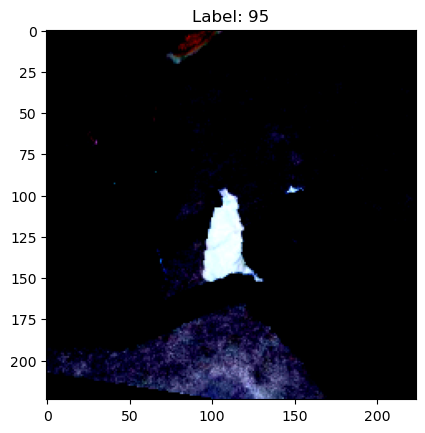

In [19]:
# 如果需要視覺化一個 batch
import matplotlib.pyplot as plt
def show_batch(loader):
    images, labels = next(iter(loader))
    img = images[0].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(f"Label: {labels[0]}")
    plt.show()

show_batch(train_loader)

In [20]:
import torch
import torch.nn as nn
import torchvision.models as models

num_classes = 120  # Dog Breed Identification 有 120 類別
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 載入預訓練模型並修改最後一層
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# 搬移到裝置（GPU 或 CPU）
model = model.to(device)

In [21]:
num_epochs = 10
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


In [22]:
for epoch in range(num_epochs):
    model.train()  # 訓練模式
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 清零梯度
        optimizer.zero_grad()

        # 前向傳播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向傳播
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 計算準確率
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # 更新學習率
    scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # 在每個 epoch 結束後評估模型在驗證集上的表現
    model.eval()  # 評估模式
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Epoch 1/10, Loss: 2.6331, Accuracy: 52.76%
Validation Loss: 1.5149, Validation Accuracy: 77.10%
Epoch 2/10, Loss: 1.5022, Accuracy: 77.95%
Validation Loss: 1.3898, Validation Accuracy: 81.26%
Epoch 3/10, Loss: 1.2911, Accuracy: 85.01%
Validation Loss: 1.3721, Validation Accuracy: 81.31%
Epoch 4/10, Loss: 1.1680, Accuracy: 88.65%
Validation Loss: 1.3720, Validation Accuracy: 81.07%
Epoch 5/10, Loss: 1.0747, Accuracy: 92.26%
Validation Loss: 1.3596, Validation Accuracy: 82.39%
Epoch 6/10, Loss: 1.0098, Accuracy: 94.56%
Validation Loss: 1.3575, Validation Accuracy: 82.24%
Epoch 7/10, Loss: 0.9602, Accuracy: 96.21%
Validation Loss: 1.3535, Validation Accuracy: 82.29%
Epoch 8/10, Loss: 0.9242, Accuracy: 97.54%
Validation Loss: 1.3215, Validation Accuracy: 83.51%
Epoch 9/10, Loss: 0.9073, Accuracy: 97.95%
Validation Loss: 1.3030, Validation Accuracy: 84.25%
Epoch 10/10, Loss: 0.8985, Accuracy: 98.42%
Validation Loss: 1.3031, Validation Accuracy: 83.76%


In [23]:
# 保存訓練後的模型
torch.save(model.state_dict(), "dog_breed_model.pth")


In [24]:
# 測試集的評估
test_accuracy = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        test_accuracy += (predicted == labels).sum().item()

test_accuracy = 100 * test_accuracy / len(val_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}%")

import os

Test Accuracy: 82.88%


In [25]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TestImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_filenames = sorted(os.listdir(image_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name.split('.')[0]  # 傳回 image tensor 和 id（

In [26]:
# 取得所有類別名稱，需排序以符合 submission 格式
all_breeds = sorted(dataset.class_to_idx.keys())

# 建立 mapping
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
# 修正 Test transform 使用與訓練相同的 ImageNet 格式
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),  # 與訓練相同
                         (0.229, 0.224, 0.225))
])


# 設定測試資料夾路徑
test_folder = 'dog-breed-identification/test'  # 請確認實際位置

# 建立 DataLoader
test_dataset = TestImageDataset(test_folder, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 建立 DataFrame 儲存預測結果
results = []

In [27]:
tta_transforms = [
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ]),
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ]),
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ]),
]

results = []

model.eval()
with torch.no_grad():
    for inputs, image_ids in test_loader:
        tta_preds = []

        for t in tta_transforms:
            augmented = torch.stack([t(transforms.ToPILImage()(img.cpu())) for img in inputs])
            augmented = augmented.to(device)

            outputs = model(augmented)
            probs = torch.softmax(outputs, dim=1)
            tta_preds.append(probs)

        # 對 TTA 結果取平均
        avg_probs = torch.stack(tta_preds).mean(dim=0)

        # 找出預測類別
        _, preds = torch.max(avg_probs, 1)

        for img_id, pred in zip(image_ids, preds.cpu()):
            breed = idx_to_class[pred.item()]
            row = {"id": img_id}
            for b in all_breeds:
                row[b] = 1 if b == breed else 0
            results.append(row)

# 輸出 submission 檔案
df = pd.DataFrame(results)
df.to_csv("submission_tta.csv", index=False)
print("✅ 使用 TTA 的 submission_tta.csv 已建立，可上傳！")


✅ 使用 TTA 的 submission_tta.csv 已建立，可上傳！
